In [1]:
import matplotlib.pyplot as plt
import pandas as pd
#import talib
import numpy as np
import lightgbm as lgb
import pyfolio as pf
import time
start_time = time.time()

/home/liaw/anaconda3/envs/finlab/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [2]:
#import tensorflow-gpu

In [3]:
import tensorflow as tf


In [4]:
print(len(tf.config.experimental.list_physical_devices('GPU')) )

0


In [5]:
from tensorflow.python.client import device_lib

In [6]:
print(device_lib.list_local_devices() )

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1105548000982797583
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2953885490045681018
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10072270877018290569
physical_device_desc: "device: XLA_GPU device"
]


In [7]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[]

In [8]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [9]:
#Step1 Get Original Data from Interactivebroker
# filename = "SPY_20040123_20200529_30min.csv" #from IB
filename = "quandl_N4N_5D_20071001~20200313.csv" #from IB
df = pd.read_csv(filename,index_col = 0)
# df.reset_index(drop=True,inplace=True)
print(df.shape)
print(df.head(1))
print(df.tail(1))

(5334, 21)
            SPF  DJF  Oil  GOLD  USD  TBF  TN5      SPFy  SPFclose  DJFy  ...  \
Date                                                                      ...   
2000-01-04  NaN  NaN  NaN   NaN  NaN  NaN  NaN  1.030103    1411.8   NaN  ...   

               GOLDy  GOLDclose      Oily  Oilclose      USDy  USDclose  \
Date                                                                      
2000-01-04  1.002664      281.5  1.008611     25.55  1.001598     100.1   

                TBFy  TBFclose      TN5y   TN5close  
Date                                                 
2000-01-04  0.984828    90.625  0.993776  97.914062  

[1 rows x 21 columns]
                 SPF       DJF       Oil  GOLD       USD       TBF       TN5  \
Date                                                                           
2020-06-12  0.008139  0.014743 -0.002201   NaN  0.005851 -0.006598 -0.000745   

            SPFy  SPFclose  DJFy  ...  GOLDy  GOLDclose  Oily  Oilclose  USDy  \
Date        

In [10]:
#Step2 check data

#Check NAN
print(df.isnull().values.any() )
print("before dropping NaN", df.shape)
df.dropna(inplace=True)
print("after dropping NaN", df.shape)

# print( df.info() )
print(type(df.index[0]), df.index[0])
df.index = pd.to_datetime(df.index)
# print( df.info() )
print(type(df.index[0]), df.index[0])

True
before dropping NaN (5334, 21)
after dropping NaN (3097, 21)
<class 'str'> 2007-10-02
<class 'pandas._libs.tslibs.timestamps.Timestamp'> 2007-10-02 00:00:00


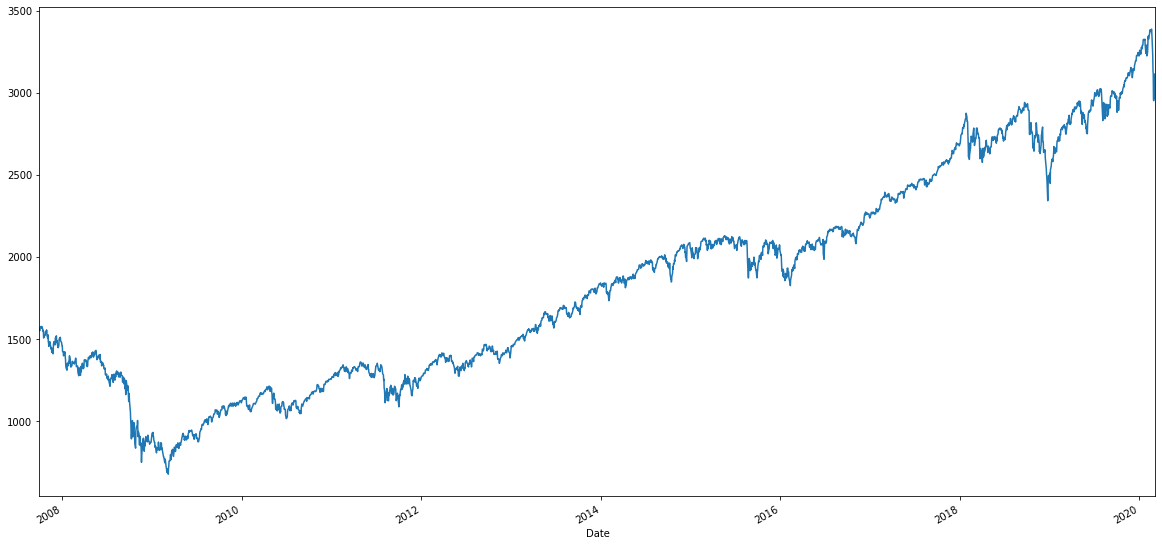

In [11]:
#Step Clean Data
# tc=df.close #targetclose
tc=df.SPFclose #targetclose

plt.rcParams["figure.figsize"] = (20,10)
tc.plot()

In [12]:
# Feature 

In [13]:

%%time 
#Wall time: 4.09 s
import numpy as np
import tqdm

time_period = 200

cnn_x = []
cnn_y = []
indexs = []
for i in tqdm.tqdm_notebook(range(0, len(tc) - time_period - 1 - 11, 3)):
    s = tc.iloc[i:i+time_period].values
    cnn_x.append((s - s.min())/(s.max() - s.min()))
    r = tc.iloc[i+time_period+10] / tc.iloc[i+time_period-1]
    cnn_y.append(r)
    indexs.append(tc.index[i+time_period-1])

cnn_x = np.array(cnn_x)
cnn_y = np.array(cnn_y)
indexes = np.array(indexs)






CPU times: user 269 ms, sys: 0 ns, total: 269 ms
Wall time: 257 ms


Reshape features and labels

In [14]:
cnn_x = cnn_x.reshape(len(cnn_x), time_period, 1)
cnn_y = cnn_y.reshape(len(cnn_y), 1)

In [15]:
# import talib
# import numpy as np
# import pandas as pd

# sma = talib.SMA(tc, timeperiod=120)
# wma = talib.WMA(tc, timeperiod=120)
# mom = talib.MOM(tc, timeperiod=120)
# k, d = talib.STOCH  (tc, tc, tc, fastk_period=120, slowk_period=60, slowd_period=60)
# k2, d2 = talib.STOCH(tc, tc, tc, fastk_period=240, slowk_period=120, slowd_period=120)
# k3, d3 = talib.STOCH(tc, tc, tc, fastk_period=360, slowk_period=180, slowd_period=180)
# k4, d4 = talib.STOCH(tc, tc, tc, fastk_period=480, slowk_period=240, slowd_period=240)
# k5, d5 = talib.STOCH(tc, tc, tc, fastk_period=640, slowk_period=320, slowd_period=320)
# k6, d6 = talib.STOCH(tc, tc, tc, fastk_period=720, slowk_period=360, slowd_period=360)
# k7, d7 = talib.STOCH(tc, tc, tc, fastk_period=840, slowk_period=420, slowd_period=420)
# k8, d8 = talib.STOCH(tc, tc, tc, fastk_period=960, slowk_period=480, slowd_period=480)

# rsi = talib.RSI (tc, timeperiod=120)
# rsi2 = talib.RSI(tc, timeperiod=240)
# rsi3 = talib.RSI(tc, timeperiod=480)
# rsi4 = talib.RSI(tc, timeperiod=640)
# rsi5 = talib.RSI(tc, timeperiod=720)
# rsi6 = talib.RSI(tc, timeperiod=840)

# macd1, macd2, macd3 = talib.MACD(tc, fastperiod=120, slowperiod=60, signalperiod=60)
# willr = talib.WILLR(tc, tc, tc, timeperiod=120)
# cci = talib.CCI(tc, tc, tc, timeperiod=120)

# dataset = pd.DataFrame({
#     'RSIb': rsi / 50,
#     'RSIb2': rsi2 / 50,
#     'RSIb3': rsi3 / 50,
#     'RSIb4': rsi4 / 50,
#     'RSIb5': rsi5 / 50,
#     'RSIb6': rsi6 / 50,
#     'MOMb': mom - 0,
#     'KDb': k - d,
#     'KDb2': k2 - d2,
#     'KDb3': k3 - d3,
#     'KDb4': k4 - d4,
#     'KDb5': k5 - d5,
#     'KDb6': k6 - d6,
#     'KDb7': k7 - d7,
#     'KDb8': k8 - d8,
    
#     'a5':   (tc.rolling(5).mean()   / tc),
#     'a10':  (tc.rolling(10).mean()  / tc),
#     'a20':  (tc.rolling(20).mean()  / tc),
#     'a40':  (tc.rolling(40).mean()  / tc),
#     'a80':  (tc.rolling(80).mean()  / tc),
#     'a160': (tc.rolling(160).mean() / tc),
#     'a320': (tc.rolling(320).mean() / tc),
#     'a640': (tc.rolling(640).mean() / tc),
#     'a720': (tc.rolling(720).mean() / tc),
#     'a840': (tc.rolling(840).mean() / tc),
#     'a960': (tc.rolling(960).mean() / tc),
#     'a1024':(tc.rolling(1024).mean() / tc),
#     'b1': tc/tc.shift(50),
#     'b2': tc/tc.shift(100),
#     'b3': tc/tc.shift(150),
#     'b4': tc/tc.shift(200),
#     'b5': tc/tc.shift(250),
#     'b6': tc/tc.shift(300),
#     'b7': tc/tc.shift(350),
#     'LINEARREG_SLOPE0': talib.LINEARREG_SLOPE(tc, 60),
#     'LINEARREG_SLOPE1': talib.LINEARREG_SLOPE(tc, 120),

#     'ADXR0': talib.ADXR(tc, tc, tc, 60),
#     'ADXR1': talib.ADXR(tc, tc, tc, 120),
#     'ADXR2': talib.ADXR(tc, tc, tc, 240),
#     'ADXR3': talib.ADXR(tc, tc, tc, 360),
#     'ADXR4': talib.ADXR(tc, tc, tc, 480),
#     'ADXR5': talib.ADXR(tc, tc, tc, 640),

#     'return': tc.shift(-10) / tc,
# })

# feature_names = list(dataset.columns[:-1])

In [16]:
# print(feature_names)

In [17]:
#print("before dropping NaN", cnn_x.shape)
#cnn_x.dropna(inplace=True)
#print("after dropping NaN", cnn_x.shape)


Split traning and testing data


In [18]:
import datetime
cnn_x_train = cnn_x[indexes < datetime.datetime(2016,1,1)]
cnn_y_train = cnn_y[indexes < datetime.datetime(2016,1,1)]

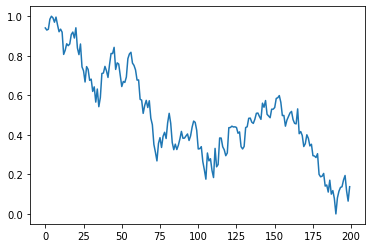

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(cnn_x[0].reshape(1, len(cnn_x[0]))[0])


In [20]:
# CNN Preprocess

In [21]:
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# dataset_scaled = ss.fit_transform(dataset[feature_names])
# dataset_scaled = pd.DataFrame(dataset_scaled, index=dataset.index, columns=feature_names)
# dataset_scaled['return'] = dataset['return']
# dataset_scaled.describe()

In [22]:
# CNN Model

In [23]:
%%time
#epoch 5 , %%time 

import keras.layers as layers
import keras
from keras.models import Sequential
from keras.initializers import he_normal

input_shape = cnn_x[0].shape
time_period = 200
num_classes = 1


model_m = Sequential()

model = keras.Sequential()

model.add(layers.Conv1D(filters=20, kernel_size=20, activation='relu', input_shape=cnn_x[0].shape))
model.add(layers.AveragePooling1D(5))

model.add(layers.Conv1D(filters=20, kernel_size=20, activation='relu'))
model.add(layers.AveragePooling1D(5))
model.add(layers.Flatten())
model.add(layers.Dense(units=120, activation='relu'))
model.add(layers.Dense(units=84, activation='relu'))
model.add(layers.Dense(units=1, ))#activation = 'softmax'))

adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.01, amsgrad=False)

model.compile(loss='mse',
                optimizer=adam)

print(model.summary())

get_best_model = keras.callbacks.ModelCheckpoint("cnn_300epoch-GPU.mdl", monitor="val_acc")







_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 181, 20)           420       
_________________________________________________________________
average_pooling1d_1 (Average (None, 36, 20)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 17, 20)            8020      
_________________________________________________________________
average_pooling1d_2 (Average (None, 3, 20)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               7320      
_________________________________________________________________
dense_2 (Dense)              (None, 84)                10164     
_____

In [24]:
#NN Training

In [25]:
%%time
#without GPU epoch  5 -> 
#without GPU epoch 50 ->  1min 26s
#without GPU epoch 100 -> Wall time: 2min 46s; GPU : 
#Without GPU epoch 200 -> : 5min 52s
#Without GPU epoch 300-> : 7min 52s
history = model.fit(cnn_x_train, cnn_y_train,
                    batch_size=200,
                    epochs=300,
                    verbose=1,
                    validation_split=0.1,
    callbacks=[get_best_model] )




Train on 555 samples, validate on 62 samples
Epoch 1/300


555/555 [==============================] - 0s 538us/step - loss: 0.9446 - val_loss: 0.8302
Epoch 2/300
555/555 [==============================] - 0s 50us/step - loss: 0.8354 - val_loss: 0.6665
Epoch 3/300
555/555 [==============================] - 0s 60us/step - loss: 0.6938 - val_loss: 0.4611
Epoch 4/300
555/555 [==============================] - 0s 42us/step - loss: 0.5106 - val_loss: 0.2295
Epoch 5/300
555/555 [==============================] - 0s 42us/step - loss: 0.3001 - val_loss: 0.0398
Epoch 6/300
555/555 [==============================] - 0s 43us/step - loss: 0.1060 - val_loss: 0.0522
Epoch 7/300
555/555 [==============================] - 0s 43us/step - loss: 0.0396 - val_loss: 0.3641
Epoch 8/300
555/555 [==============================] - 0s 42us/step - loss: 0.1065 - val_loss: 0.4258
Epoch 9/300
555/555 [==============================] - 0s 38us/step - loss: 0.0941 - val_loss: 0.2309
Epoch 10/300
555/555 [==========

555/555 [==============================] - 0s 41us/step - loss: 0.0039 - val_loss: 0.0096
Epoch 72/300
555/555 [==============================] - 0s 41us/step - loss: 0.0039 - val_loss: 0.0119
Epoch 73/300
555/555 [==============================] - 0s 46us/step - loss: 0.0037 - val_loss: 0.0105
Epoch 74/300
555/555 [==============================] - 0s 39us/step - loss: 0.0036 - val_loss: 0.0101
Epoch 75/300
555/555 [==============================] - 0s 36us/step - loss: 0.0036 - val_loss: 0.0105
Epoch 76/300
555/555 [==============================] - 0s 37us/step - loss: 0.0035 - val_loss: 0.0106
Epoch 77/300
555/555 [==============================] - 0s 37us/step - loss: 0.0035 - val_loss: 0.0093
Epoch 78/300
555/555 [==============================] - 0s 44us/step - loss: 0.0034 - val_loss: 0.0109
Epoch 79/300
555/555 [==============================] - 0s 36us/step - loss: 0.0034 - val_loss: 0.0106
Epoch 80/300
555/555 [==============================] - 0s 91us/step - loss: 0.0033 - 

555/555 [==============================] - 0s 37us/step - loss: 0.0018 - val_loss: 0.0049
Epoch 151/300
555/555 [==============================] - 0s 35us/step - loss: 0.0018 - val_loss: 0.0051
Epoch 152/300
555/555 [==============================] - 0s 41us/step - loss: 0.0019 - val_loss: 0.0044
Epoch 153/300
555/555 [==============================] - 0s 36us/step - loss: 0.0018 - val_loss: 0.0052
Epoch 154/300
555/555 [==============================] - 0s 45us/step - loss: 0.0018 - val_loss: 0.0044
Epoch 155/300
555/555 [==============================] - 0s 39us/step - loss: 0.0018 - val_loss: 0.0045
Epoch 156/300
555/555 [==============================] - 0s 38us/step - loss: 0.0018 - val_loss: 0.0050
Epoch 157/300
555/555 [==============================] - 0s 37us/step - loss: 0.0018 - val_loss: 0.0043
Epoch 158/300
555/555 [==============================] - 0s 39us/step - loss: 0.0018 - val_loss: 0.0046
Epoch 159/300
555/555 [==============================] - 0s 41us/step - loss: 

Epoch 229/300
555/555 [==============================] - 0s 40us/step - loss: 0.0016 - val_loss: 0.0035
Epoch 230/300
555/555 [==============================] - 0s 40us/step - loss: 0.0015 - val_loss: 0.0027
Epoch 231/300
555/555 [==============================] - 0s 42us/step - loss: 0.0015 - val_loss: 0.0036
Epoch 232/300
555/555 [==============================] - 0s 44us/step - loss: 0.0015 - val_loss: 0.0033
Epoch 233/300
555/555 [==============================] - 0s 39us/step - loss: 0.0015 - val_loss: 0.0026
Epoch 234/300
555/555 [==============================] - 0s 40us/step - loss: 0.0015 - val_loss: 0.0035
Epoch 235/300
555/555 [==============================] - 0s 39us/step - loss: 0.0015 - val_loss: 0.0034
Epoch 236/300
555/555 [==============================] - 0s 47us/step - loss: 0.0015 - val_loss: 0.0026
Epoch 237/300
555/555 [==============================] - 0s 38us/step - loss: 0.0015 - val_loss: 0.0033
Epoch 238/300
555/555 [==============================] - 0s 39us

In [26]:
# Verify

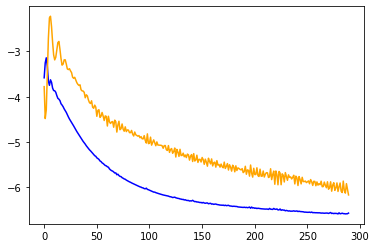

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.log(history.history['loss'][10:]),c='blue')
plt.plot(np.log(history.history['val_loss'][10:]),c='orange')

In [28]:
print(len(history.history['loss']))     #200
print(len(history.history['val_loss'])) #200

300
300


In [29]:
model.load_weights("cnn_300epoch-GPU.mdl")

In [30]:
ey = model.predict(cnn_x)
ey = pd.Series(ey.swapaxes(0, 1)[0], index=indexes)

In [31]:
eq = tc[pd.to_datetime(indexes)]

In [32]:
gain = (eq.shift(-1) - eq) 
signal = (ey > ey.quantile(0.9)).rolling(20).sum() > 0


In [33]:
eq = (gain[signal])['2016':].cumsum()

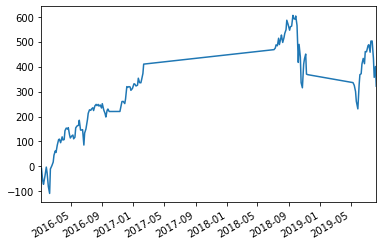

In [34]:
eq.plot()

In [35]:
eq.pct_change()[eq.pct_change() == eq.pct_change().max() ]

2016-01-29    7.714286
Name: SPFclose, dtype: float64

In [36]:
signal['2016':].astype(int).diff().abs().sum()

7.0

In [37]:
import pyfolio as pf 

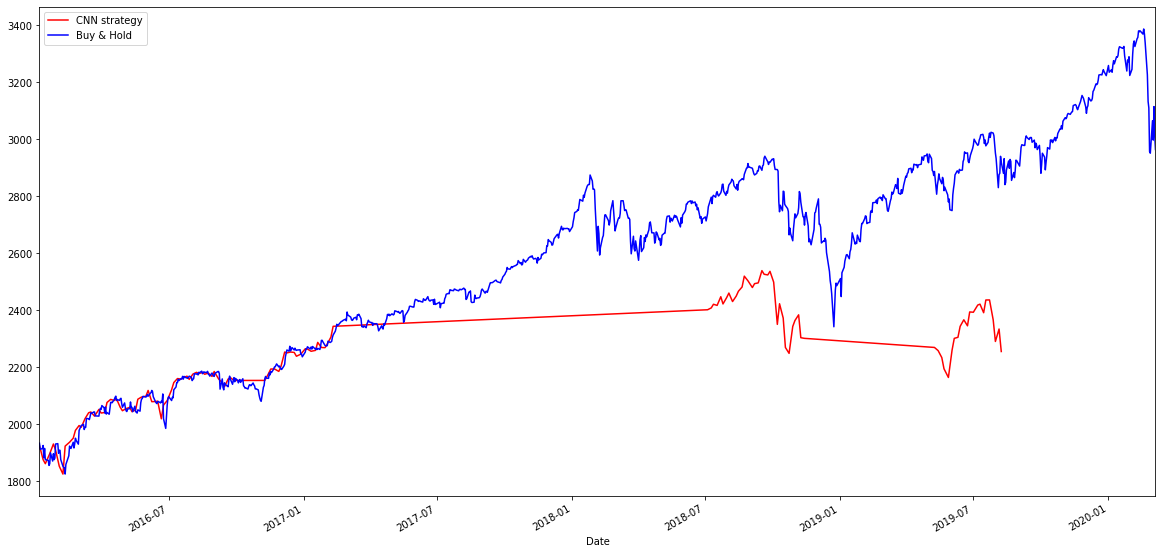

In [38]:
eq_relative = eq + tc[tc.index == eq.index[0]][0]
tw_relative = tc[eq.index[0]:]
plt.rcParams["figure.figsize"] = (20,10)
"""
        plt.rcParams["figure.figsize"] = (20,10)
        (hold*10).plot(label="hold")
        
        eq=creturn
        
        eq_relative = eq + tc[tc.index == eq.index[0]][0]
        bm_relative = tc[eq.index[0]:]

        eq_relative.plot(c="red",  label="BIAS strategy")
        bm_relative.plot(c="blue", label="Buy & Hold" )
        
#         creturn.plot(c="blue", label="BIAS strategy")
#         (tc-tc[0]).plot(c="red", label="Buy & Hold")
        plt.legend(loc='best')
"""
eq_relative.plot(c="red",  label="CNN strategy")
tw_relative.plot(c="blue", label="Buy & Hold")
plt.legend(loc='best')
eqpc = eq_relative.pct_change()
bmpc = tw_relative.pct_change() 

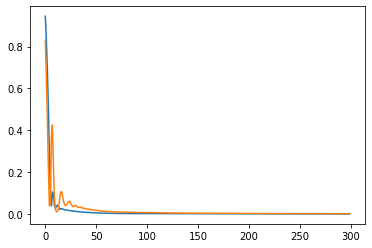

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

Start date,2016-01-07
End date,2019-08-09
Total months,6
,Backtest
Annual return,33.5%
Cumulative returns,17.1%
Annual volatility,24.4%
Sharpe ratio,1.31
Calmar ratio,2.27
Stability,0.74
Max drawdown,-14.8%


/home/liaw/anaconda3/envs/finlab/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.77,2018-09-17,2019-05-29,NaT,NaN
1,5.47,2016-01-26,2016-02-08,2016-02-17,17
2,4.70,2016-06-03,2016-06-21,2016-07-05,23
3,3.32,2016-01-07,2016-01-15,2016-01-26,14
4,2.45,2016-09-01,2016-09-15,2016-11-17,56


/home/liaw/anaconda3/envs/finlab/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


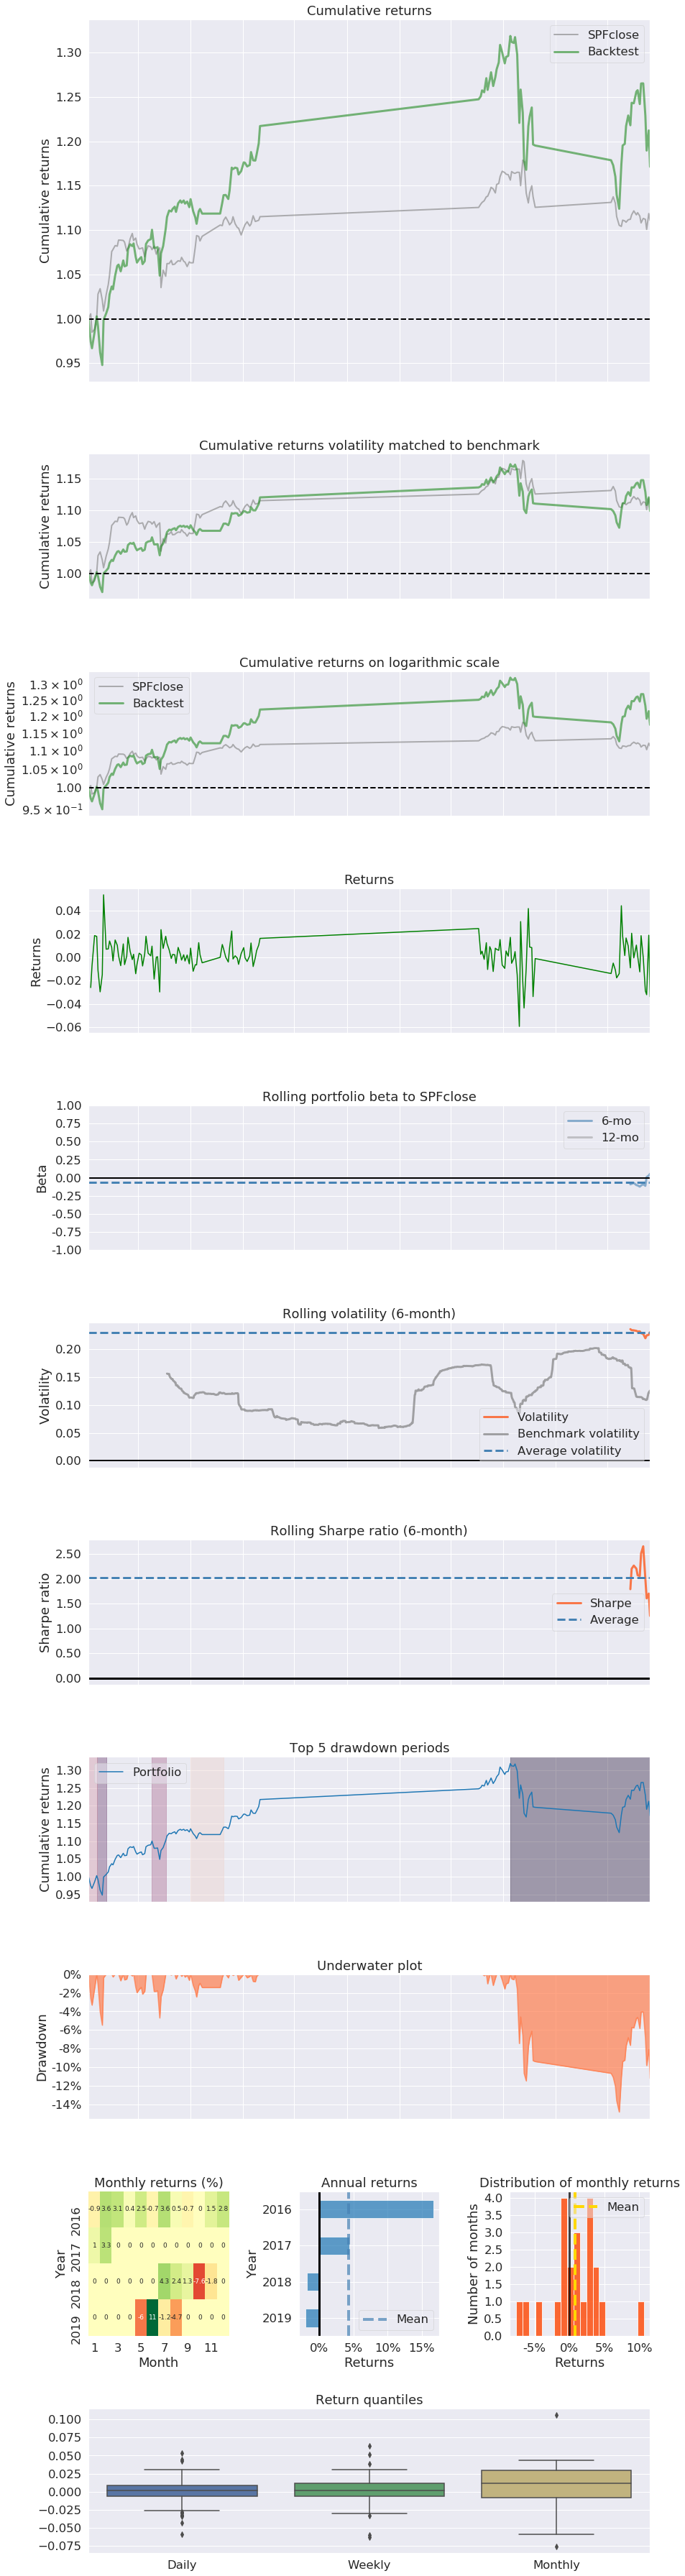

In [40]:
pf.create_returns_tear_sheet( eqpc, benchmark_rets=bmpc )  #relative

In [41]:
print("My program took ", time.time()-start_time, "torun")


My program took  21.652442693710327 torun
